In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
dataset_dir = '../input/dataset/Training.csv'
column_names = ['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact', 'Meme creativity', 'Soap slipperiness','Hype root']

df = pd.read_csv(dataset_dir, header=0, names=column_names)

# Split over users
df_test = df.loc[:6852]
df_train = df.loc[6852:68529]
df_train.shape, df_test.shape

((61676, 7), (6853, 7))

In [4]:
test_size = 6853
X_train_raw = df.iloc[:-test_size]
X_test_raw = df.iloc[-test_size:]

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

'''
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Sponginess')
plt.plot(X_test_raw.Sponginess, label='Sponginess')
plt.title('Train-Test Split')
plt.legend()
plt.show()
'''

"\nplt.figure(figsize=(17,5))\nplt.plot(X_train_raw.Sponginess, label='Sponginess')\nplt.plot(X_test_raw.Sponginess, label='Sponginess')\nplt.title('Train-Test Split')\nplt.legend()\nplt.show()\n"

In [5]:
# Initializing window, stride, validation set size and telescope (direct method)
window = 800
stride = 10
validation_size = 12000
target_labels = df.columns
telescope = 864

In [6]:
future = df[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 800, 7)

In [7]:
def build_sequences(df, target_labels=target_labels, window=window, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [8]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_val, y_val = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6074, 800, 7), (6074, 864, 7), (554, 800, 7), (554, 864, 7))

## Direct Forecasting 

In [9]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [10]:
# Building the model
def build_CONV_LSTM_model(input_shape, output_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    convlstm = tfkl.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(input_layer)
    convlstm = tfkl.Dropout(.1)(convlstm)
    convlstm = tfkl.LSTM(128, recurrent_dropout=0.2)(convlstm)
    convlstm = tfkl.Dropout(.1)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss = tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', 'mse', tfk.metrics.RootMeanSquaredError()])

    # Return the model
    return model

In [11]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

2021-12-25 19:44:09.552133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 19:44:09.638360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 19:44:09.639109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 19:44:09.640235: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 800, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 800, 64)           18432     
_________________________________________________________________
dropout (Dropout)            (None, 800, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6048)              780192    
_________________________________________________________________
reshape (Reshape)            (None, 864, 7)            0     

In [12]:
# Training
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val,y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)]
).history

2021-12-25 19:44:12.629413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-12-25 19:44:20.751071: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


95/95 [==============================] - 519s 5s/step - loss: 0.0964 - mae: 0.2353 - mse: 0.0964 - root_mean_squared_error: 0.3105 - val_loss: 0.0374 - val_mae: 0.1420 - val_mse: 0.0374 - val_root_mean_squared_error: 0.1934
Epoch 2/200
95/95 [==============================] - 509s 5s/step - loss: 0.0320 - mae: 0.1315 - mse: 0.0320 - root_mean_squared_error: 0.1789 - val_loss: 0.0312 - val_mae: 0.1328 - val_mse: 0.0312 - val_root_mean_squared_error: 0.1767
Epoch 3/200
95/95 [==============================] - 510s 5s/step - loss: 0.0265 - mae: 0.1212 - mse: 0.0265 - root_mean_squared_error: 0.1628 - val_loss: 0.0278 - val_mae: 0.1254 - val_mse: 0.0278 - val_root_mean_squared_error: 0.1666
Epoch 4/200
95/95 [==============================] - 506s 5s/step - loss: 0.0229 - mae: 0.1134 - mse: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0244 - val_mae: 0.1181 - val_mse: 0.0244 - val_root_mean_squared_error: 0.1562
Epoch 5/200
95/95 [==============================] - 509s 5s/step - 

In [13]:
model.save('trained/DirectForecasting')
!zip -r DirectForecasting.zip  ./trained/DirectForecasting

2021-12-26 03:20:39.665327: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


  adding: trained/DirectForecasting/ (stored 0%)
  adding: trained/DirectForecasting/saved_model.pb (deflated 89%)
  adding: trained/DirectForecasting/assets/ (stored 0%)
  adding: trained/DirectForecasting/keras_metadata.pb (deflated 90%)
  adding: trained/DirectForecasting/variables/ (stored 0%)
  adding: trained/DirectForecasting/variables/variables.index (deflated 66%)
  adding: trained/DirectForecasting/variables/variables.data-00000-of-00001 (deflated 8%)


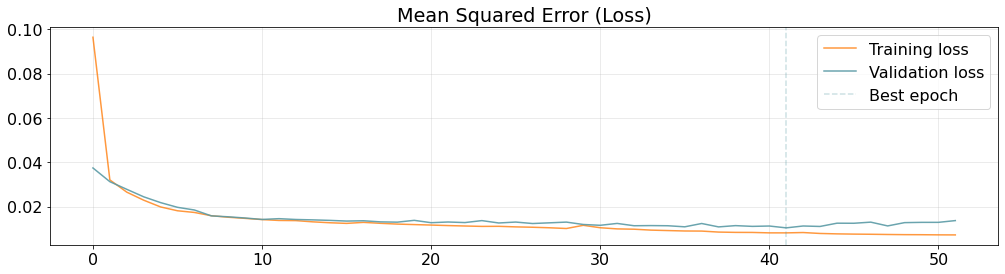

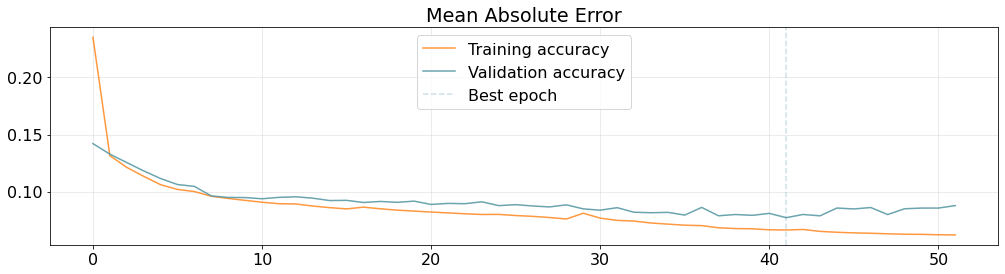

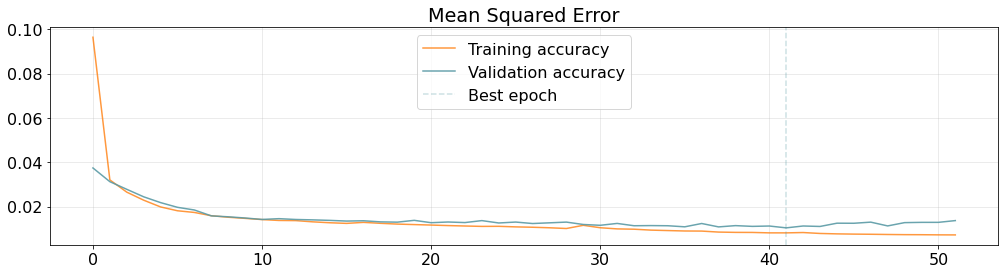

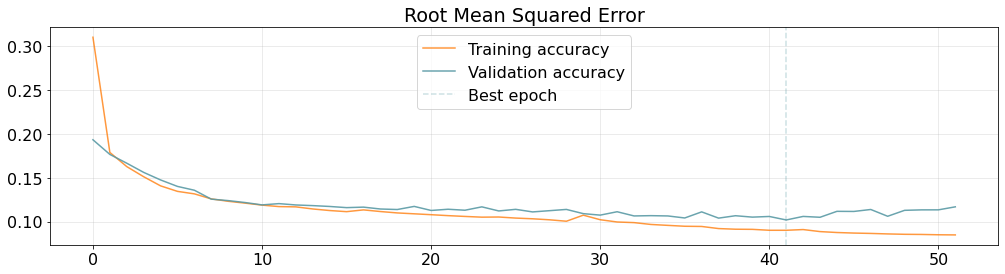

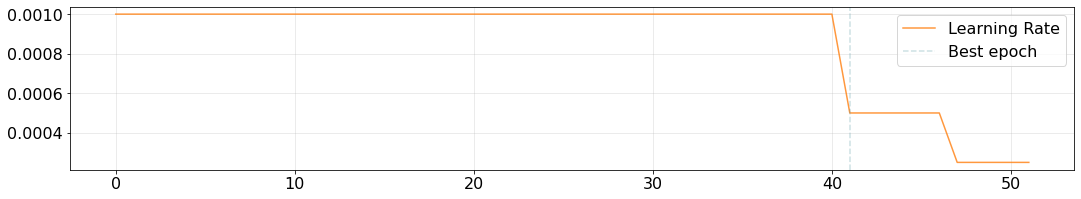

In [14]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mse'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mse'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['root_mean_squared_error'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_root_mean_squared_error'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Root Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [15]:
# Predict the test set 
predictions = model.predict(X_val)

In [16]:
mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
root_mean_squared_error = tfk.metrics.RootMeanSquaredError()
root_mean_squared_error.update_state(y_val.flatten(),predictions.flatten())
print('RMSE: ', root_mean_squared_error.result().numpy())
print('MSE: ', mean_squared_error)
print('MAE: ', mean_absolute_error)

RMSE:  0.10180993
MSE:  tf.Tensor(0.010365262, shape=(), dtype=float32)
MAE:  tf.Tensor(0.077092655, shape=(), dtype=float32)


In [17]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

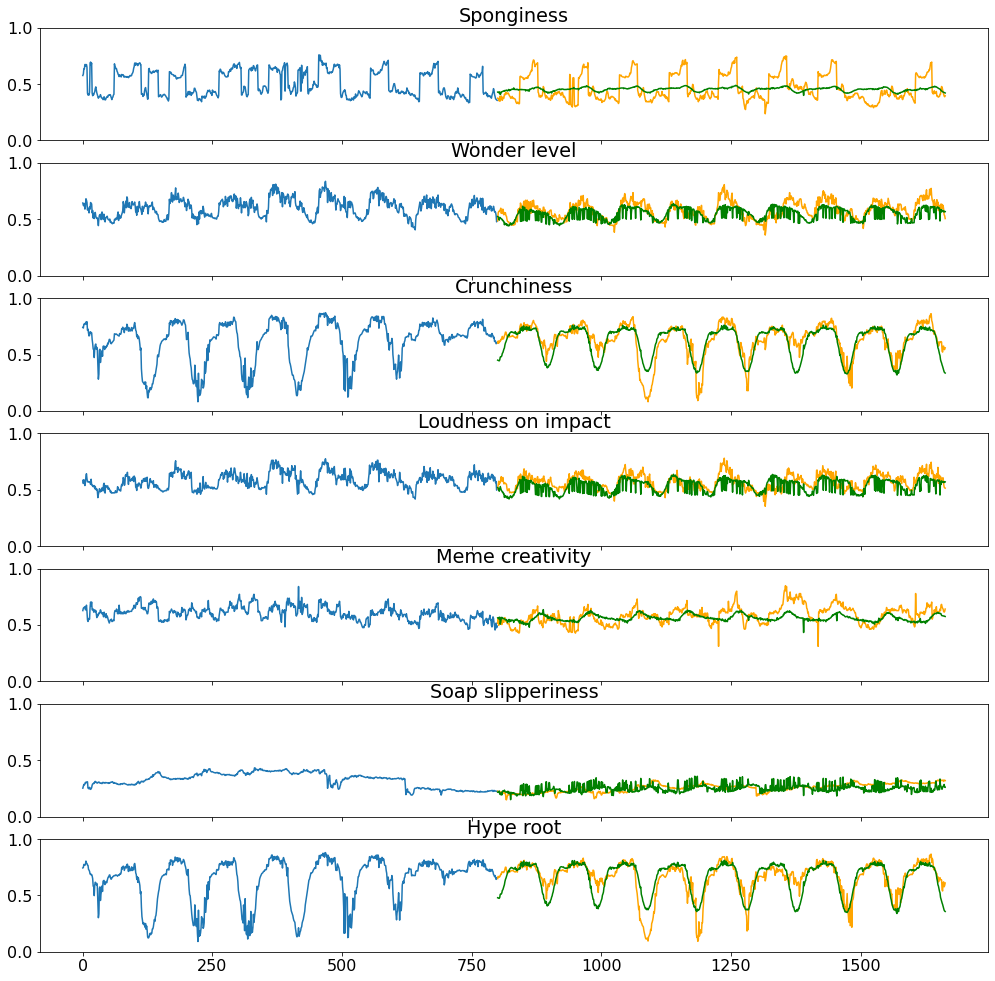

In [18]:
inspect_multivariate_prediction(X_val, y_val, predictions, target_labels, telescope)